In [1]:
import yaml
from pymatgen.io.vasp import Xdatcar
import numpy as np
from site_analysis_functions import tetrahedral_site_analysis
from site_analysis_functions import site_populations
import matplotlib.pyplot as plt
from collections import Counter

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.safe_load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [3]:
def site_transitions(analysis):
    unassignable = 0
    assignable = 0
    transitions = {'1': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}),
                   '2': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}),
                   '3': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}), 
                   '4': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}), 
                   '5': Counter({'1':0, '2':0, '3':0, '4':0, '5':0})}
    for atom_trajectory in np.array(analysis.atoms_trajectory).T:
        for i, j in zip(atom_trajectory[:-1], atom_trajectory[1:]):
            if i != j:
                site_i = analysis.site_by_index(i)
                site_j = analysis.site_by_index(j)
                neighbouring_sites = analysis.site_collection.neighbouring_sites(i)
                if site_j.index in [ s.index for s in neighbouring_sites ]:
                    transitions[site_i.label][site_j.label] += 1
                else:
                    n_sites_i = analysis.site_collection.neighbouring_sites(i)
                    n_sites_j = analysis.site_collection.neighbouring_sites(j)
                    intermediate_site = set([s.index for s in n_sites_i]) & set([s.index for s in n_sites_j])
                    if len(intermediate_site) == 1:
                        site_int = analysis.site_by_index(list(intermediate_site)[0])
                        transitions[site_i.label][site_int.label] += 1
                        transitions[site_int.label][site_j.label] += 1
                        assignable += 1
                    else:
                        unassignable += 1
    print(f'{unassignable} changes not assigned of {unassignable+assignable}')
    return transitions

In [4]:
data_dir = '../../data'

x_spec = {'Li6PS5I': 'I', 'Li6PS5Cl': 'Cl'}

transitions = {}
populations = {}
for system in md_runs:
    transitions[system] = {}
    populations[system] = {}
    for disorder, runs in md_runs[system].items():
        print(f'Analysing {system} > {disorder}')
        xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
        xdatcars = (Xdatcar( f ) for f in xdatcar_filenames)
        structures = flatten_list([x.structures for x in xdatcars])
        trajectory = tetrahedral_site_analysis(structures, x_spec[system])
        populations[system][disorder] = site_populations(trajectory)
        transitions[system][disorder] = site_transitions(trajectory)

Analysing Li6PS5I > 0p
max mapping disp = 0.26 Angstroms



0 changes not assigned of 19
Analysing Li6PS5I > 50p
max mapping disp = 0.58 Angstroms



8 changes not assigned of 353
Analysing Li6PS5I > 100p
max mapping disp = 0.43 Angstroms



44 changes not assigned of 488
Analysing Li6PS5Cl > 0p
max mapping disp = 0.89 Angstroms



37 changes not assigned of 522
Analysing Li6PS5Cl > 50p
max mapping disp = 0.78 Angstroms



86 changes not assigned of 1112
Analysing Li6PS5Cl > 100p
max mapping disp = 0.60 Angstroms



58 changes not assigned of 1670


In [5]:
def get_data(st):
    data = np.array([[st['2']['2'], st['4']['2'], st['5']['2']],
                     [st['2']['4'], st['4']['4'], st['5']['4']],
                     [st['2']['5'], st['4']['5'], st['5']['5']]])
    data = data / data.sum(axis=0)
    return data.T # following right stochastic matrix convention: https://en.wikipedia.org/wiki/Stochastic_matrix

In [6]:
import matplotlib as mpl


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=0.0, vmax=1.0, **kwargs)

#     # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

#     # Turn spines off and create white grid.
#     for edge, spine in ax.spines.items():
#         spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j] > 0:
                if np.ma.is_masked(data):
                    if not data.mask[i,j]:
                        kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                        texts.append(text)
                else:
                    kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                    text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                    texts.append(text)
    return texts

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


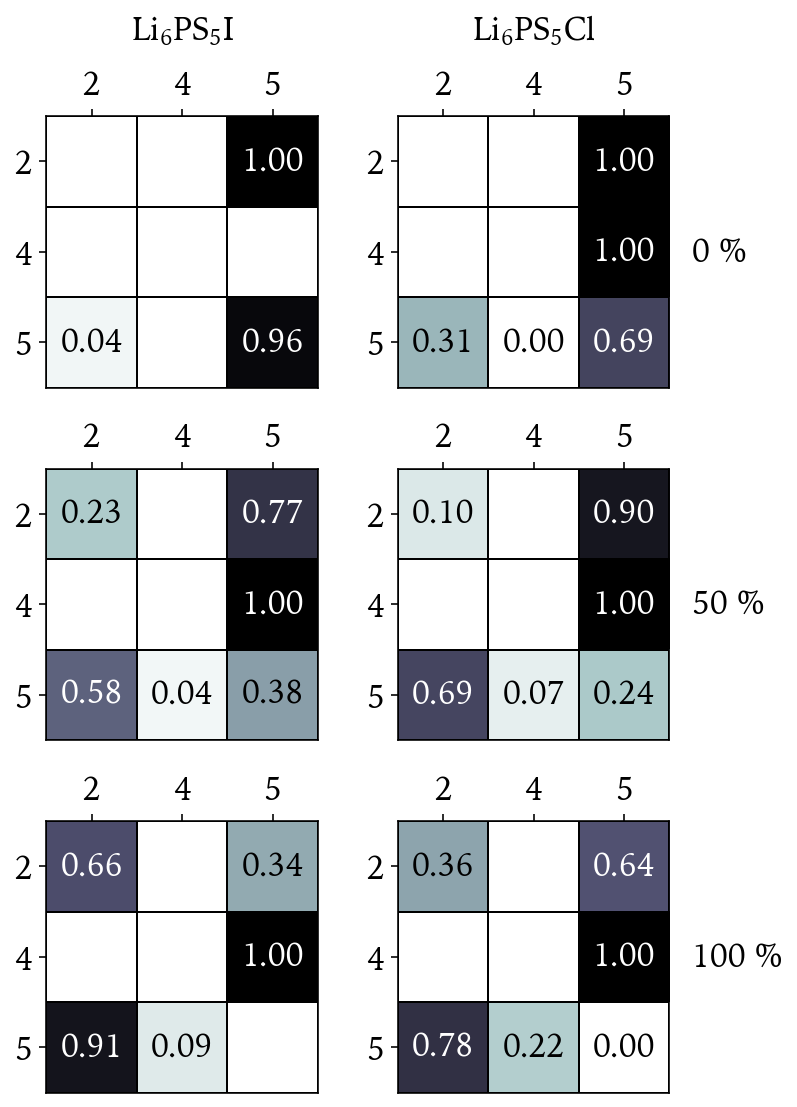

In [7]:
from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"

rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 16})

cmap = "bone_r"
sites = [2,4,5]
fig, ax = plt.subplots(3,2, figsize=(5.9,8))

data = get_data(transitions['Li6PS5I']['0p'])
im = heatmap(data, sites, sites, ax=ax[0,0],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5Cl']['0p'])
im = heatmap(data, sites, sites, ax=ax[0,1],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5I']['50p'])

im = heatmap(data, sites, sites, ax=ax[1,0],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5Cl']['50p'])
im = heatmap(data, sites, sites, ax=ax[1,1],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5I']['100p'])
im = heatmap(data, sites, sites, ax=ax[2,0],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5Cl']['100p'])
im = heatmap(data, sites, sites, ax=ax[2,1],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15, size=16)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15, size=16)
ax[0,1].text(2.75,1.1,'0 %')
ax[1,1].text(2.75,1.1,'50 %')
ax[2,1].text(2.75,1.1,'100 %')

fig.tight_layout()
plt.savefig('../../figures/transition_matrices.pdf')
plt.show()

In [8]:
%load_ext version_information

%version_information yaml, pymatgen, tqdm, numpy, site_analysis, matplotlib

Software versions
Python 3.7.0 64bit [Clang 10.0.0 (clang-1000.10.44.2)]
IPython 7.0.1
OS Darwin 19.4.0 x86_64 i386 64bit
yaml 5.2
pymatgen 2020.1.28
tqdm 4.46.0
numpy 1.18.3
site_analysis 0.0.2
matplotlib 3.2.0rc1
Wed May 20 23:05:13 2020 BST